In [8]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import six

In [9]:
# some function I copied from the internet (https://stackoverflow.com/questions/26678467/export-a-pandas-dataframe-as-a-table-image)
# it can be used to generate pdf from tables from "pandas" library
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax


## Mie-Gruneisen

In [10]:
#for aluminium, taken from the table EOS.pdf
rho0 = 2.78
gamma0 = 2.
#define the k_i and epsilon_i as arrays
# the order is [k3,k2,k1,k0=0] and [epsilon04,epsilon03,epsilon02,epsilon01,epsilon00]
k = np.array([2.130e0, 1.325e0, 7.906e-1, 0.]) # the 0 is because k0 = 0
e0 = np.array([3.16e-1, 2.495e-1, 1.364e-1, -5.547e-3, -2.773e-3])
kb = 1.38064852e-16 #boltzmann constant
m = 4.48038989e-23 #mass of an atom of aluminium

# the table gives the value with the pressure in units of Mega Bar - we need to turn them into the units
# of pressure in c.g.s which are called "barye"
# other than that all the units are c.g.s
MBar_to_Barye = 1.e12
k = k * MBar_to_Barye
e0 = e0 * MBar_to_Barye

#define mie-grunessian function as function of rho and T
def mie_grunessian(rho, T):
    x =  1 - rho0/rho
    epsilon0 = np.polyval(e0, x)
    P = np.polyval(k, x) + gamma0 * rho0 * (3* kb * T / m + epsilon0)
    return P

## Numerical Derivative

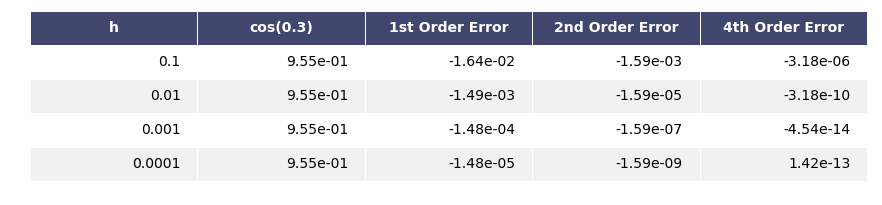

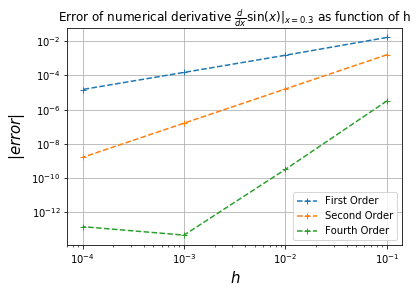

In [11]:
x = 0.3

f = np.sin #define f(x) to be sin(x)

first_order = []
second_order = []
fourth_order = []

#define value of h to work on
h = np.array([0.1, 0.01, 0.001, 0.0001])

#calculate the different order derivatives
first_order = ( f(x+h) - f(x) ) / h
second_order = ( f(x+h) - f(x-h) ) / (2*h)
fourth_order =  ( -(1/12)*f(x+2*h) + (2/3)*f(x+h) - (2/3)*f(x-h) + (1/12)*f(x-2*h) ) / h

real_derivative = np.full(len(h), np.cos(x)) #create list in the length of the h_values with the real derivative

#calculate errors in the calculation of derivative
first_order_error = first_order - real_derivative
second_order_error = second_order - real_derivative
fourth_order_error = fourth_order - real_derivative

#edit table for output
table = pd.DataFrame()
table['h'] = h
# insert the derivative and the errors to the table
# we format them to show only 2 digits using the 'f'{y:.2e}' command
table[f'cos({x})'] = [f'{y:.2e}' for y in real_derivative]
table['1st Order Error'] = [f'{y:.2e}' for y in first_order_error]
table['2nd Order Error'] = [f'{y:.2e}' for y in second_order_error]
table['4th Order Error'] = [f'{y:.2e}' for y in fourth_order_error]
render_mpl_table(table, header_columns=0, col_width=3.0) #create a table plot
plt.savefig('figs/derivative_errors.pdf', dpi=200, bbox_inches = 'tight') #save the plot in pdf


#print graph of error as function of h (for all orders)
plt.figure(2) #create second figure
plt.loglog(h, np.abs(first_order_error), '+--')
plt.plot(h, np.abs(second_order_error), '+--')
plt.plot(h, np.abs(fourth_order_error), '+--')
plt.legend(['First Order', 'Second Order', 'Fourth Order'])
plt.title(r'Error of numerical derivative $\frac{d}{dx}\sin(x)|_{x=0.3}$ as function of h')
plt.xlabel('$h$', size=15)
plt.ylabel(r'$\left |error \right |$', size=15)
plt.grid()
plt.savefig(f'figs/error_as_function_of_h.pdf', dpi=250, bbox_inches = 'tight') # Save the plot
plt.show()

## Newton-Raphson : Aluminium

### Definitions

In [12]:
atmospheres = 1000
P_al = 1013250 * atmospheres #this is the atmospheres in c.g.s units
T_al = 300 #300 kelvin degrees

#this function takes x = 1 - rho0/rho to rho (by the formula rho = rho0/(1-x))
def x_to_rho(x):
    return rho0 / (1-x)

#define mie-grunessian function as function of x (which will be 1 - rho0/rho)
#this is used to find x if T and P are known
def mie_grunessian_NR(x):
    epsilon0 = np.polyval(e0, x)
    return -P_al + np.polyval(k, x) + gamma0 * rho0 * (3* kb * T_al / m + epsilon0)

#we get the coefficient of the derivative using np.polyder
k_div = np.polyder(k)
e0_div = np.polyder(e0)
def mie_grunessian_NR_div(x):
    epsilon0 = np.polyval(e0_div, x)
    return np.polyval(k_div, x) + gamma0 * rho0 * epsilon0

### Calculation

In [13]:
N = 10 #number of iterations
x_NR = [0.] # first guess for NR = newton-raphson

for n in range(N):
    x_prev = x_NR[-1] # last x is x_n
    x_NR.append( x_prev - mie_grunessian_NR(x_prev) / mie_grunessian_NR_div(x_prev) ) # = x_(n+1), add it to the list

#last element is the final guess
rho = x_to_rho(x_NR[-1])
print(f'aluminium density in {atmospheres} atmospheres is {rho}')

aluminium density in 1000 atmospheres is 2.783691209932681


## Newton Raphson vs Secant

### Define Functions

In [14]:
# define f as the function x-cos(x) 
def f(x): 
    return x - np.cos(x)

# define f' as the function 1+sin(x) 
def f_div(x):
    return 1 + np.sin(x)

N = 6 # number of iterations

### Newton-Raphson with Guess 1

In [15]:
x_NR = [0.] # first guess for NR = newton-raphson

for n in range(N):
    x_prev = x_NR[-1] # last x is x_n
    x_NR.append( x_prev - f(x_prev) / f_div(x_prev) ) # = x_(n+1)

### Newton-Raphson with Guess 2

In [16]:
x_NR2 = [3.] # first guess for NR = newton-raphson

for n in range(N):
    x_prev = x_NR2[-1] # last x is x_n
    x_NR2.append( x_prev - f(x_prev) / f_div(x_prev) ) # = x_(n+1)

### Secant with Guess 1

In [17]:
x_sec = [-1., 1.] # first guess for secant

for n in range(N):
    x_prev_prev = x_sec[-2] # one before last x is x_(n-1)
    x_prev = x_sec[-1] # last x is x_n
    f_div_approx = (f(x_prev) - f(x_prev_prev)) / (x_prev - x_prev_prev) #first order approximation
    x_sec.append( x_prev - f(x_prev) / f_div_approx ) # = x_(n+1)

### Secant with Guess 2

In [18]:
x_sec2 = [-5., 5.] # first guess for secant

for n in range(N):
    x_prev_prev = x_sec2[-2] # one before last x is x_(n-1)
    x_prev = x_sec2[-1] # last x is x_n
    f_div_approx = (f(x_prev) - f(x_prev_prev)) / (x_prev - x_prev_prev) #first order approximation
    x_sec2.append( x_prev - f(x_prev) / f_div_approx ) # = x_(n+1)

In [19]:
#some comments on the previous block:
# 1. I wrote the same code to x_sec and x_sec2 - in a better world, it is needed to got out to a method like you learned in previous classes (automation!!!)
# 2. In the the loop for secant I call the function "f" 3 times - if I saved all the previous values I could do it with only 1 call!

### Print Table

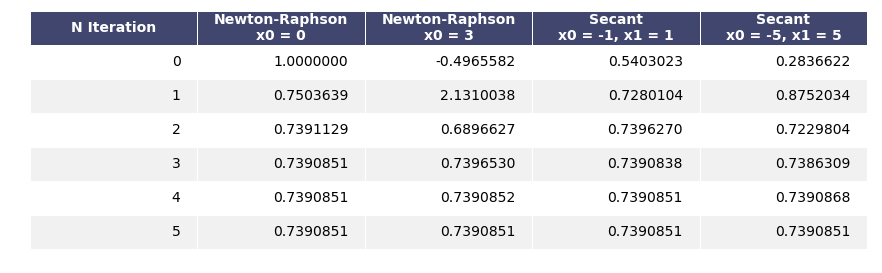

In [29]:
table = pd.DataFrame()
table['N Iteration'] = list(range(N))
table['Newton-Raphson\nx0 = 0'] = [f'{y:.7f}' for y in x_NR[1:]]
table['Newton-Raphson\nx0 = 3'] = [f'{y:.7f}' for y in x_NR2[1:]]
table['Secant\nx0 = -1, x1 = 1'] = [f'{y:.7f}' for y in x_sec[2:]]
table['Secant\nx0 = -5, x1 = 5'] = [f'{y:.7f}' for y in x_sec2[2:]]
render_mpl_table(table, header_columns=0, col_width=3.)
plt.savefig('figs/zero_finding_errors.pdf', dpi=200, bbox_inches = 'tight')

## Bonus - Newton Raphson / Secant Using Numpy!

In [29]:
from scipy.optimize import newton as newton_raphson

# define f as the function x-cos(x) 
def f(x): 
    return x - np.cos(x)

# define f' as the function 1+sin(x) 
def f_div(x):
    return 1 + np.sin(x)


# we define a tolerance so abs(f(x)) < tolerance for the result we get from the numpty method
tolerance = 1.e-5

x_NR = newton_raphson(f, x0 = 0., fprime = f_div, tol = tolerance)
print(f'numpy newthon raphson method zero is {x_NR:.13f}')


#if we do not define fprime - it uses the secant method
x_sec = newton_raphson(f, x0 = 0., tol = tolerance)
print(f'numpy secant method zero is {x_sec:.13f}')

numpy newthon raphson method zero is 0.7390851332152
numpy secant method zero is 0.7390851332150
